<a href="https://colab.research.google.com/github/hnioua/Classroom/blob/main/Tutorial_Visual_Content_Similarity_based_Recommender_System_for_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As the name suggests, the content-based method recommends based on the additional content (metadata) about the customers or products. For products, this content may be product title, description, images, category/subcategory, specification, etc.

So, this approach recommends the products by finding the most similar products to a given product based on the content.

In this tutorial, we will implement a content-based recommendation system by utilising the product images. Basically, the goal is to recommend product images that are very similar to a recently bought/checked product image.

Therefore, this image-based recommendation will be helpful in recommending the most similar products to the customers based on their recent shopping behaviour/platform usage.

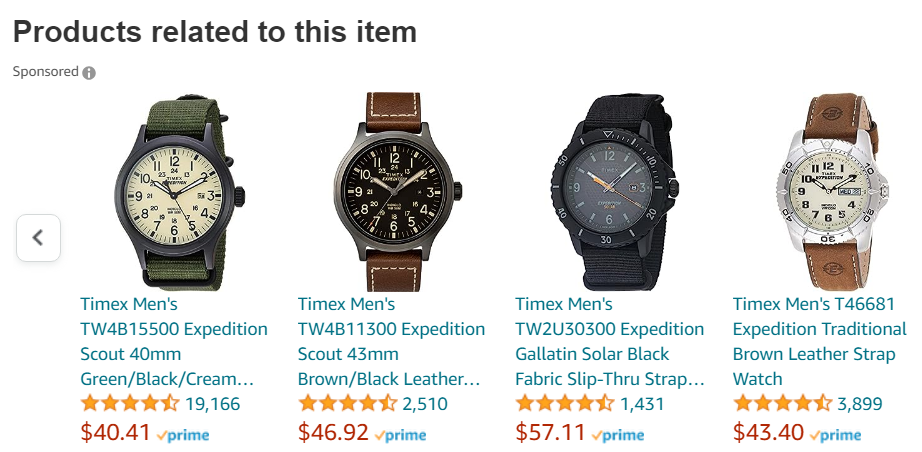


##Dataset
Implementation using the Fashion Product Images Dataset.
https://www.kaggle.com/datasets/vikashrajluhaniwal/fashion-images

The dataset contains 2906 product images across four different gender categories (men, women, boys, and girls). It also contains various product features like title, category, subcategory, colour, gender, type, usage, etc.

###Basic Data Analysis

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import requests
from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
#use the below library while displaying the images in jupyter notebook
from IPython.display import display, Image

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

fashion_df = pd.read_csv('gdrive/MyDrive/RS/E-commerce/fashion.csv')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
fashion_df

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...
2901,51755,Women,Footwear,Shoes,Casual Shoes,Black,Casual,Catwalk Women Black Shoes,51755.jpg,http://assets.myntassets.com/v1/images/style/p...
2902,47630,Women,Footwear,Shoes,Flats,Blue,Casual,Carlton London Women Blue Shoes,47630.jpg,http://assets.myntassets.com/v1/images/style/p...
2903,32836,Women,Footwear,Shoes,Flats,Pink,Casual,Grendha Women Flori Pink Sandals,32836.jpg,http://assets.myntassets.com/v1/images/style/p...
2904,35821,Women,Footwear,Shoes,Heels,Black,Casual,Enroute Women Black Heels,35821.jpg,http://assets.myntassets.com/v1/images/style/p...


 ## Basic statistics

In [ ]:
print("Total number of products : ", fashion_df.shape[0])
print("Total number of unique subcategories : ", fashion_df["SubCategory"].nunique())
print("Total number of unique gender types : ", fashion_df["Gender"].nunique())

Total number of products :  2906
Total number of unique subcategories :  9
Total number of unique gender types :  4


In [ ]:
#Frequency of each gender
fashion_df["Gender"].value_counts()

Men      811
Women    769
Boys     759
Girls    567
Name: Gender, dtype: int64

##Data Preparation

In [ ]:
apparel_boys = fashion_df[fashion_df["Gender"]=="Boys"]
apparel_girls = fashion_df[fashion_df["Gender"]=="Girls"]
footwear_men = fashion_df[fashion_df["Gender"]=="Men"]
footwear_women = fashion_df[fashion_df["Gender"]=="Women"]

##Feature Extraction using ResNet

Generally, the product image contains a unique pattern along with its colour, shape, and edges.

Images with the same kind of such features are supposed to be similar. Therefore, extracting such features from the images will be very helpful in order to recommend the most similar products.

How to extract features from the images?

Computer vision techniques can be used to extract features from the images. Here, since we have limitations on data size, compute resources, and time, so let’s use the standard pre-trained models like ResNet to extract the features. Such pre-trained models are already fine-tuned and trained on a huge dataset (like ImageNet). This process is also known as transfer learning.

####ResNet

ResNet is an abbreviated form of Residual Networks, first proposed by Kaiming He in 2015. Currently, it is perceived as a classical neural network for many computer vision tasks. In 2015, during the ImageNet Challenge, this model out-performed previous models like GoogleNet, VGGNet, and AlexNet.


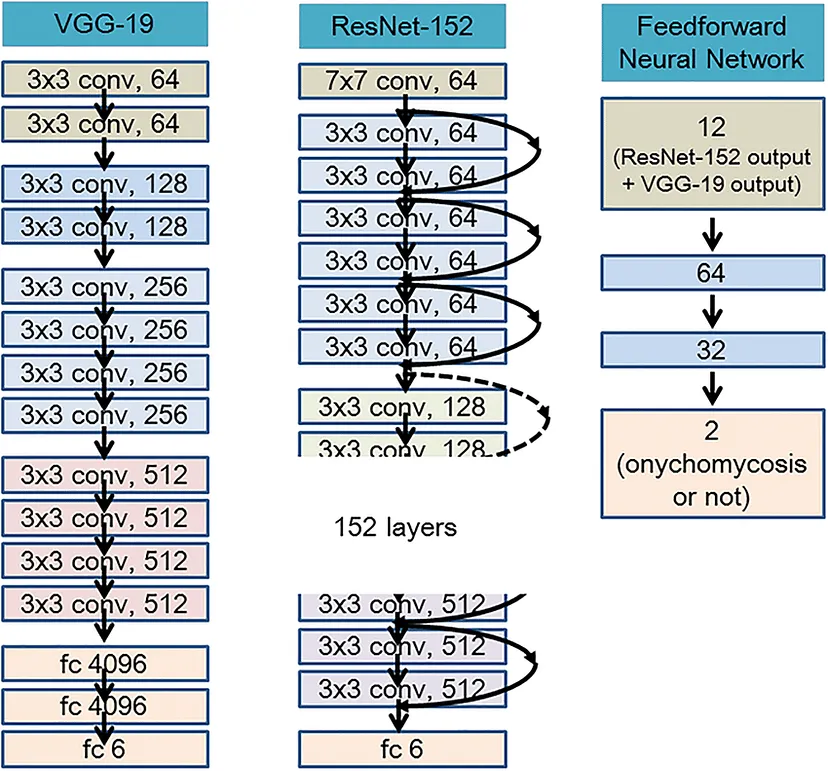
The architecture allows us to train an extremely deep and wide network with 152 layers successfully. In our implementation, we will use ResNet50 (a smaller version of ResNet152) to extract the features.



In [ ]:
# Set the image dimensions for preprocessing
img_width, img_height = 224, 224

# Specify the directory containing the training images
train_data_dir = "gdrive/MyDrive/RS/E-commerce/Footwear/Men/Images/"

# Define the number of training samples, epochs, and batch size
nb_train_samples = 811
epochs = 50
batch_size = 1

# Define a function to extract features from images
def extract_features():
    # Initialize an empty list to store item codes
    Itemcodes = []

    # Create an image data generator to preprocess the images
    datagen = ImageDataGenerator(rescale=1. / 255)

    # Load a pre-trained ResNet50 model without the top classification layers
    model = applications.ResNet50(include_top=False, weights='imagenet')

    # Generate a data flow from the training directory
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    # Extract product codes from file names
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])

    # Extract features from images and reshape them
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((811, 100352))

    # Save the extracted features and product codes as numpy arrays
    np.save(open('gdrive/MyDrive/RS/E-commerce/Footwear/Men/Images/Men_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('gdrive/MyDrive/RS/E-commerce/Footwear/Men/Images/Men_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))

# Measure the time taken for feature extraction
a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)


94765736/94765736 [==============================] - 1s 0us/step
Found 817 images belonging to 1 classes.


<ipython-input-7-e866280983b7>:36: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)


Time taken in feature extraction 0:02:39.555027


###Computing the Euclidean distance and recommending similar products

####Loading the extracted features

In [ ]:
extracted_features = np.load('gdrive/MyDrive/RS/E-commerce/Footwear/Men/Images/Men_ResNet_features.npy')
Productids = np.load('gdrive/MyDrive/RS/E-commerce/Footwear/Men/Images/Men_ResNet_feature_product_ids.npy')
men = footwear_men.copy()
#men = pd.read_csv('./footwear_men.csv')
df_Productids = list(men['ProductId'])
Productids = list(Productids)

####Distance computation and Recommendation

==================== Input Product Image ====================


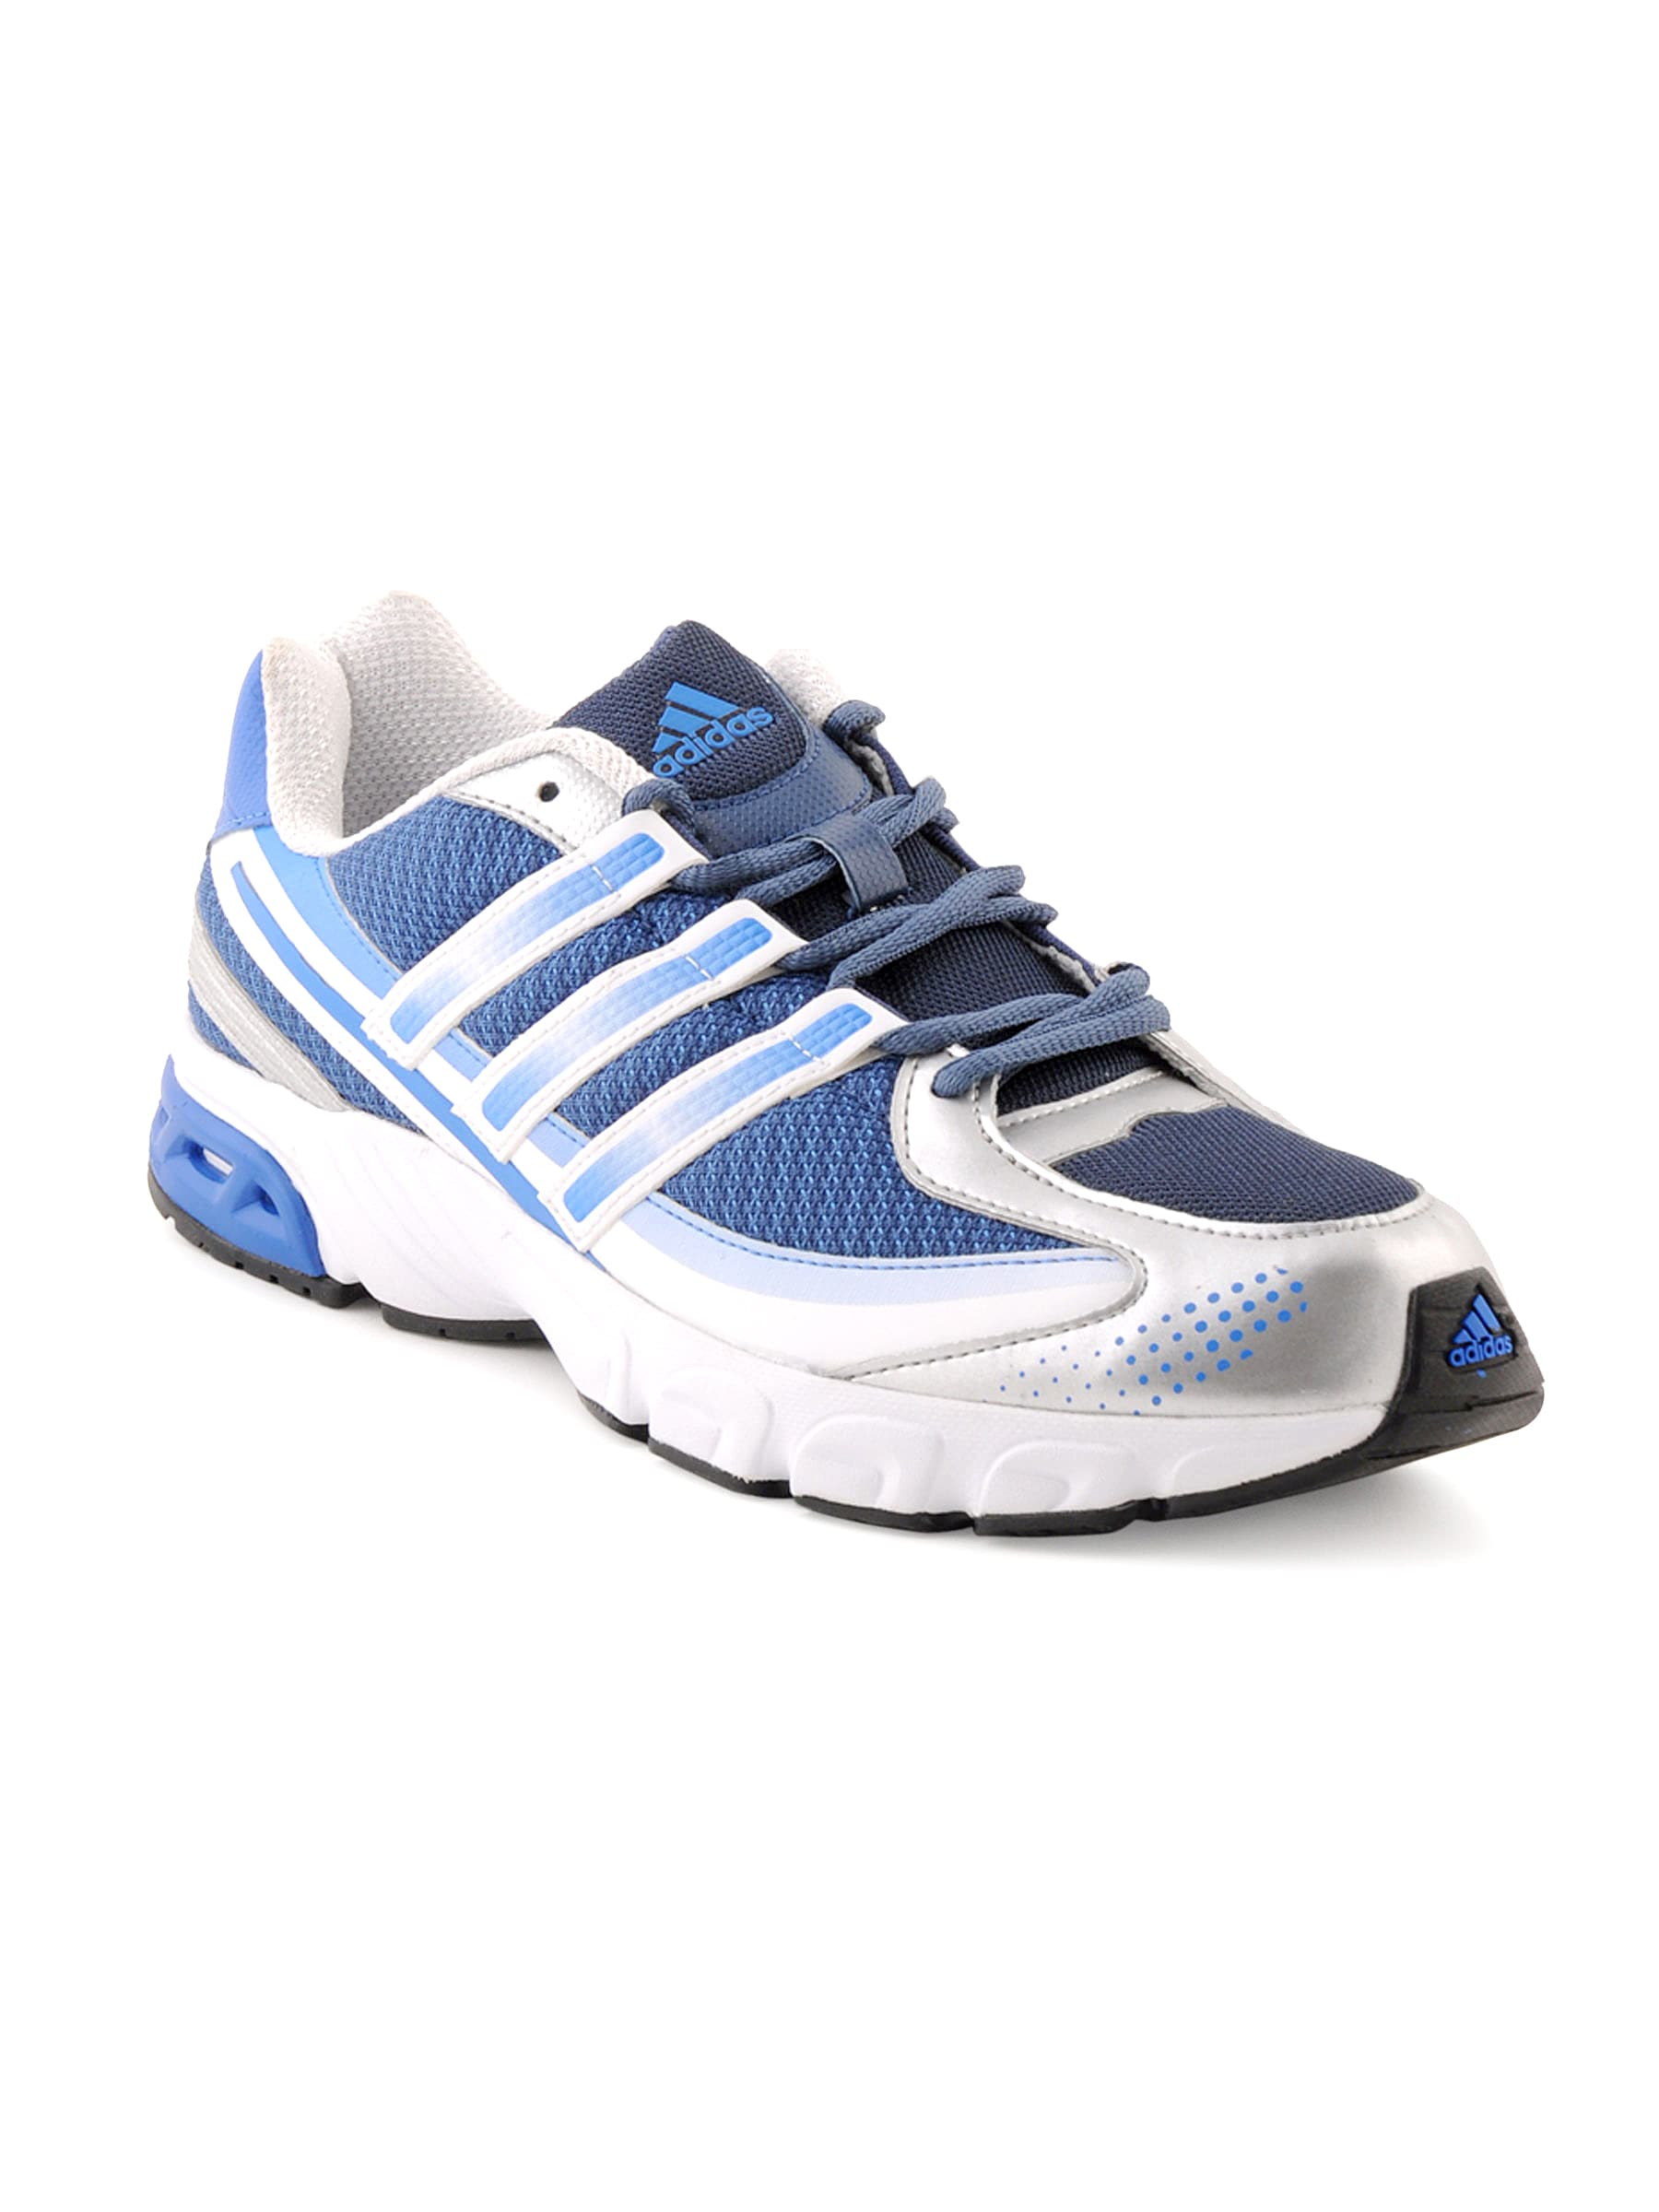

Product Title:  ADIDAS Men Adi Quest Blue Sports Shoes

 ==================== Recommended Products ====================


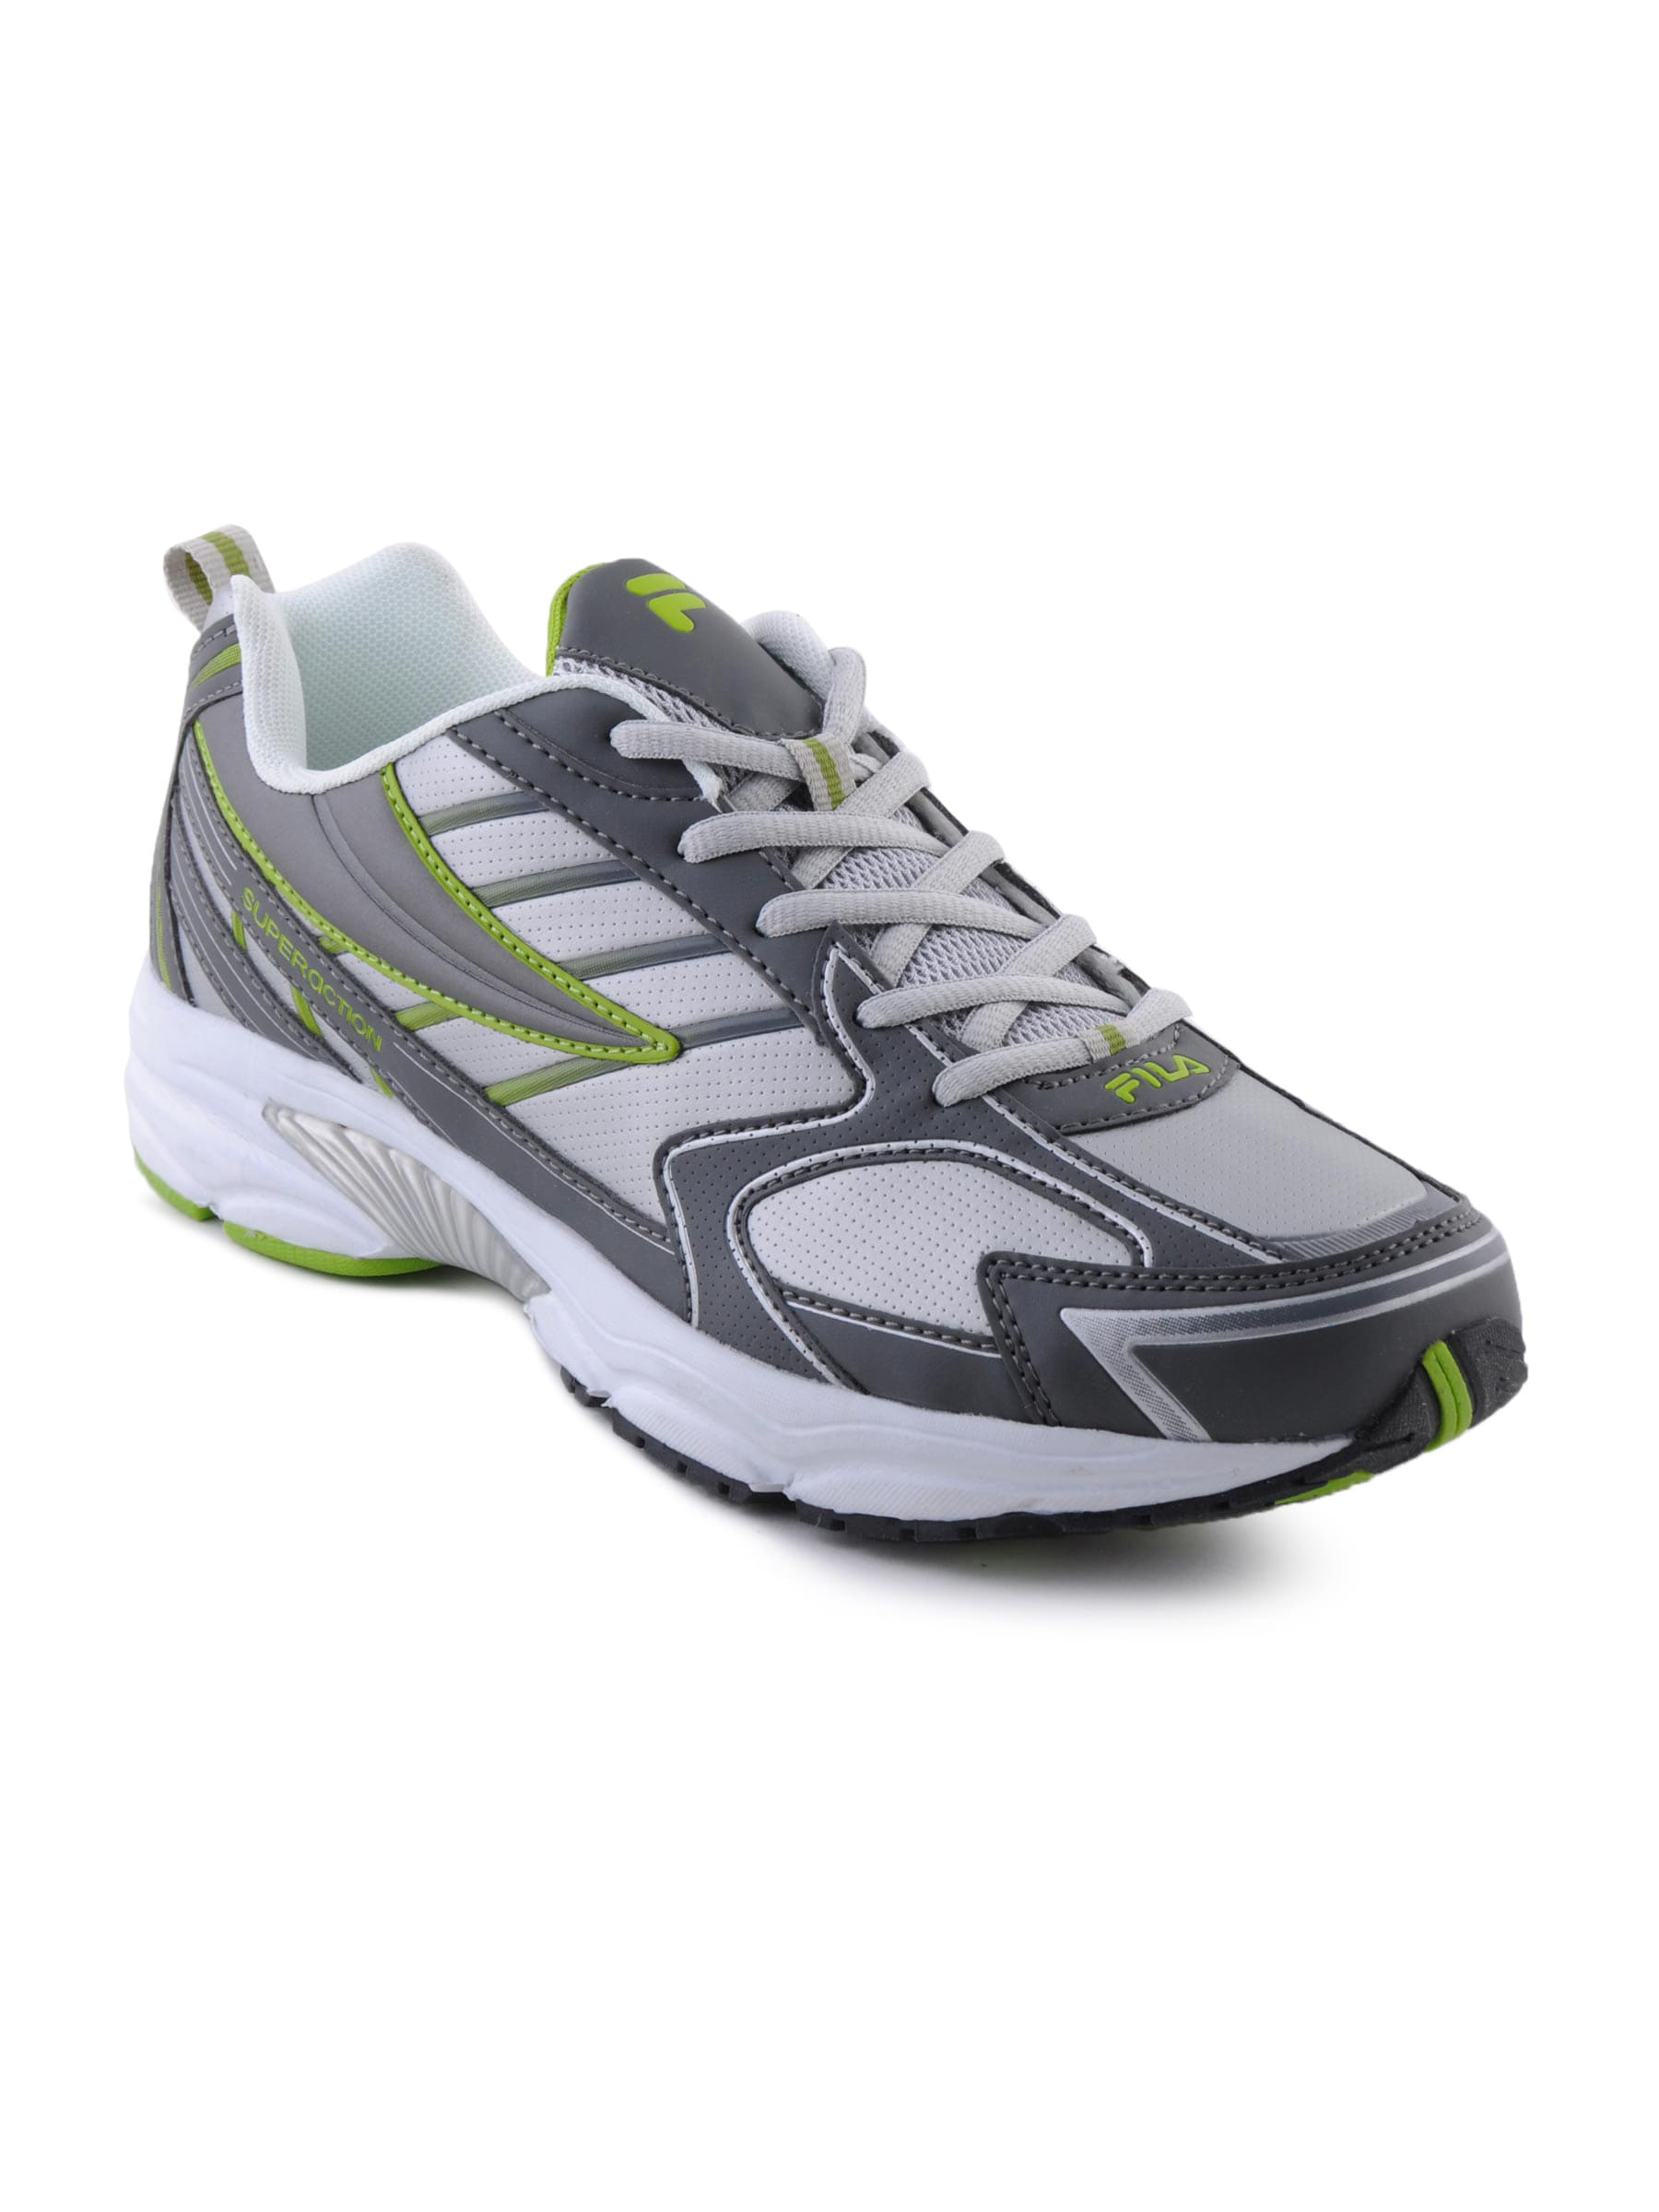

Product Title:  Fila Men Destiny Grey Sports Shoes
Euclidean Distance from Input Image: 27.646381


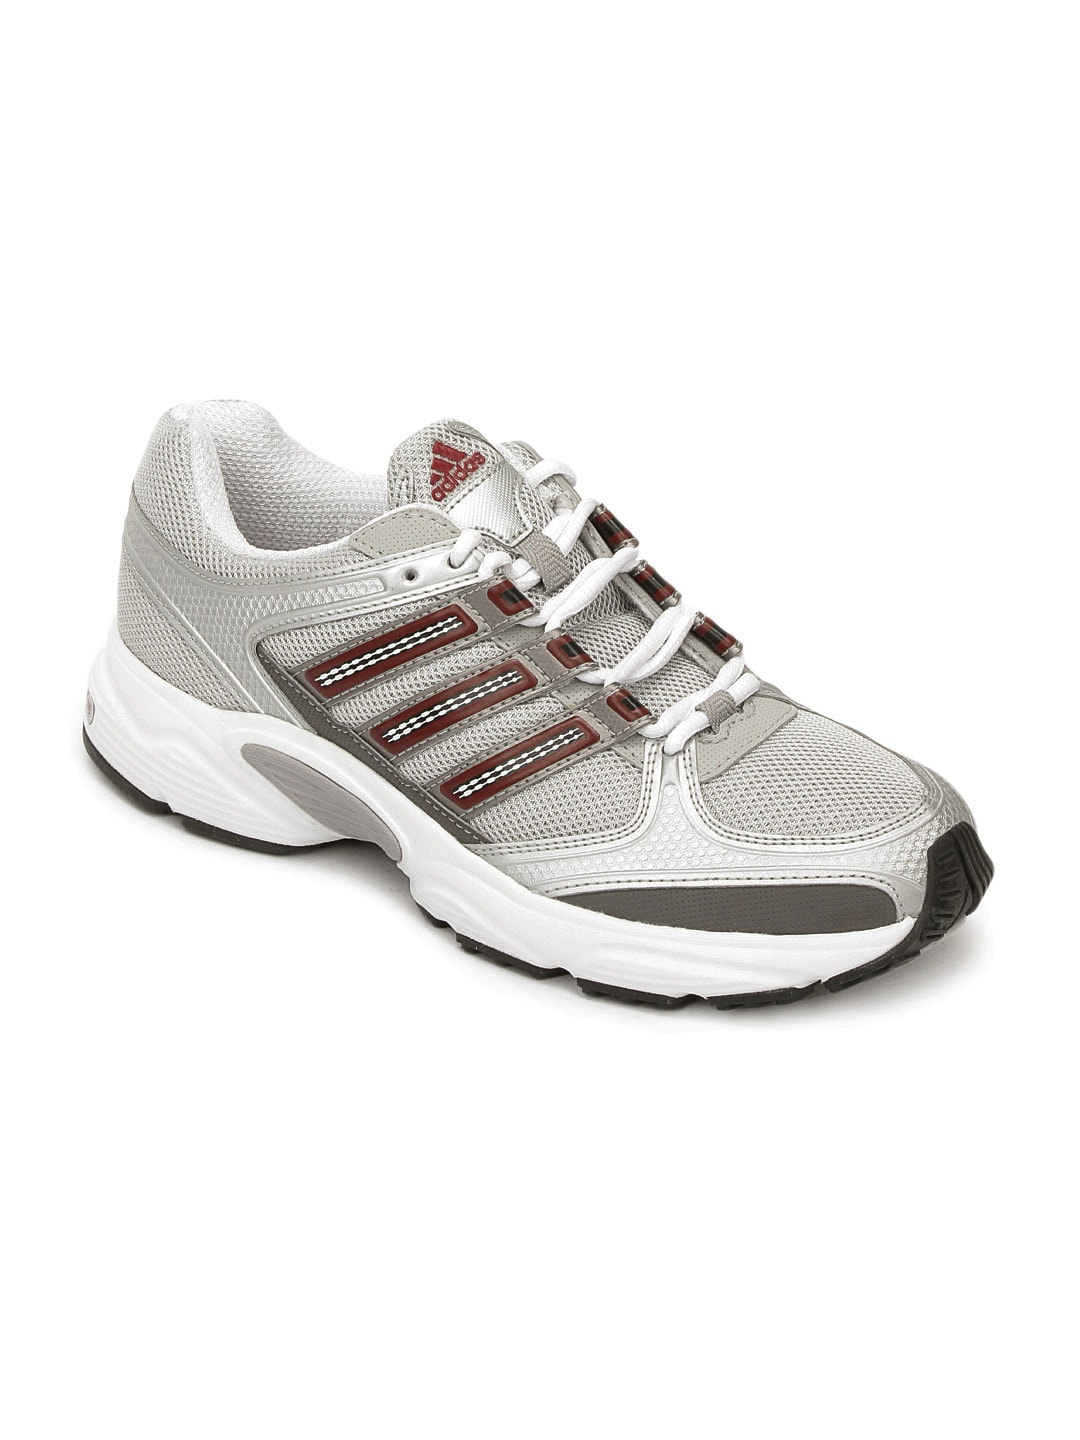

Product Title:  ADIDAS Men Silver Phaedra Shoes
Euclidean Distance from Input Image: 29.374065


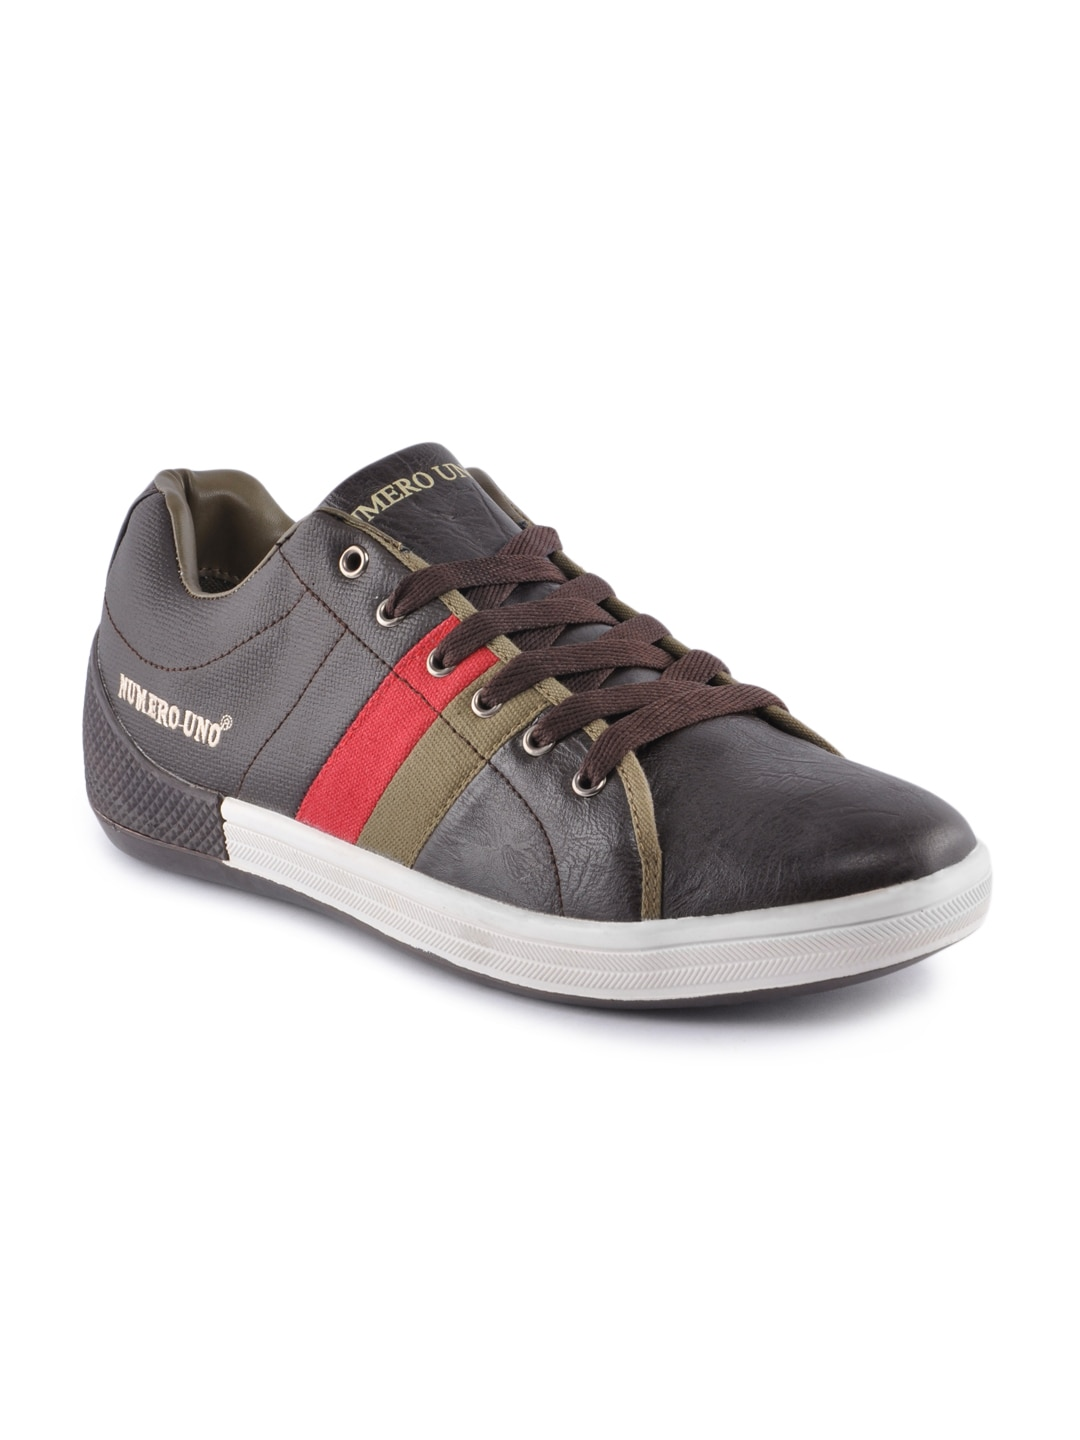

Product Title:  Numero Uno Men Brown Casual Shoes
Euclidean Distance from Input Image: 30.170918


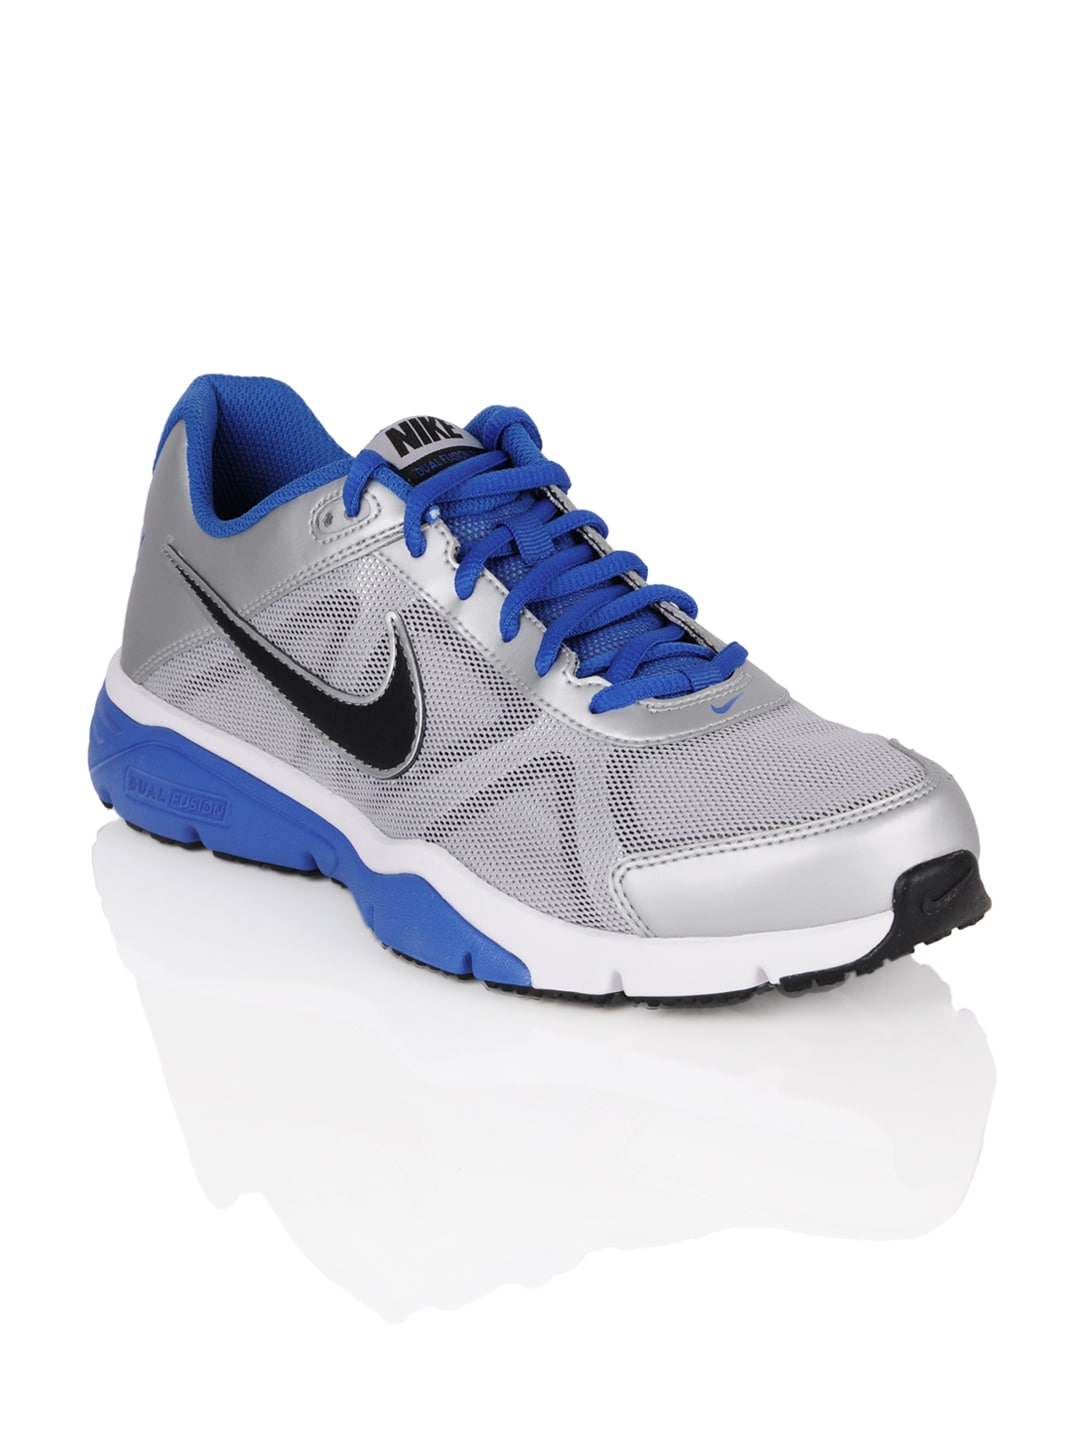

Product Title:  Nike Men Dual Fusion TR III Grey Sports Shoes
Euclidean Distance from Input Image: 30.894958


In [ ]:
def get_similar_products_cnn(product_id, num_results):
    # Find the index of the input product ID in the list of product IDs
    doc_id = Productids.index(product_id)

    # Calculate pairwise Euclidean distances between the input product and all other products' features
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))

    # Sort the indices based on the computed distances to find the most similar products
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]

    # Sort the distances as well
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    # Print a header for the input product image
    print("="*20, "Input Product Image", "="*20)

    # Get the details (ImageURL and ProductTitle) of the most similar product
    ip_row = men[['ImageURL','ProductTitle']].loc[men['ProductId']==int(Productids[indices[0]])]

    # Display the input product image and details
    for indx, row in ip_row.iterrows():
        display(Image(url=row['ImageURL'], width=224, height=224, embed=True))
        print('Product Title: ', row['ProductTitle'])

    # Print a header for recommended products
    print("\n","="*20, "Recommended Products", "="*20)

    # Loop through and display the recommended products along with their details and Euclidean distances
    for i in range(1, len(indices)):
        rows = men[['ImageURL','ProductTitle']].loc[men['ProductId']==int(Productids[indices[i]])]
        for indx, row in rows.iterrows():
            display(Image(url=row['ImageURL'], width=224, height=224, embed=True))
            print('Product Title: ', row['ProductTitle'])
            print('Euclidean Distance from Input Image:', pdists[i])

# Call the function with a sample product ID ('13683') and specify the number of similar products to recommend (5)
get_similar_products_cnn('13683', 5)


**NOTE** - The above feature extraction process can be repeated for other genders (Women, Boys and Girls) as well. So let's extract for each one by one.

**For Gender - Women**

In [ ]:
# Set the image dimensions for preprocessing
img_width, img_height = 224, 224

# Specify the directory containing the training images for women's footwear
train_data_dir = "gdrive/MyDrive/RS/E-commerce/Footwear/Women/Images/"

# Define the number of training samples, epochs, and batch size
nb_train_samples = 769
epochs = 50
batch_size = 1

# Define a function to extract features from images
def extract_features():
    # Initialize an empty list to store item codes
    Itemcodes = []

    # Create an image data generator to preprocess the images
    datagen = ImageDataGenerator(rescale=1. / 255)

    # Load a pre-trained ResNet50 model without the top classification layers
    model = applications.ResNet50(include_top=False, weights='imagenet')

    # Generate a data flow from the training directory
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    # Extract product codes from file names
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])

    # Extract features from images and reshape them
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((769, 100352))

    # Save the extracted features and product codes as numpy arrays
    np.save(open('gdrive/MyDrive/RS/E-commerce/Footwear/Women/Images/Women_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('gdrive/MyDrive/RS/E-commerce/Footwear/Women/Images/Women_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))

# Measure the time taken for feature extraction
a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)


Found 769 images belonging to 1 classes.


<ipython-input-10-a4321e40c604>:36: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)


Time taken in feature extraction 0:02:41.203975


#####For Gender - Boys

In [ ]:
img_width, img_height = 224, 224


#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = "gdrive/MyDrive/RS/E-commerce/Apparel/Boys/Images"

nb_train_samples = 759
epochs = 50
batch_size = 1

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((759, 100352))

    np.save(open('gdrive/MyDrive/RS/E-commerce/Apparel/Boys/Boys_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('gdrive/MyDrive/RS/E-commerce/Apparel/Boys/Boys_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))

a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

Found 759 images belonging to 1 classes.


<ipython-input-11-245ee4591f66>:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)


Time taken in feature extraction 0:03:35.876061


#####For Gender - Girls



In [ ]:
img_width, img_height = 224, 224


#top_model_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
train_data_dir = "gdrive/MyDrive/RS/E-commerce/Apparel/Girls/Images"

nb_train_samples = 567
epochs = 50
batch_size = 1

def extract_features():
    Itemcodes = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    model = applications.ResNet50(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    for i in generator.filenames:
        Itemcodes.append(i[(i.find("/")+1):i.find(".")])
    extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)
    extracted_features = extracted_features.reshape((567, 100352))

    np.save(open('gdrive/MyDrive/RS/E-commerce/Apparel/Girls/Girls_ResNet_features.npy', 'wb'), extracted_features)
    np.save(open('gdrive/MyDrive/RS/E-commerce/Apparel/Girls/Girls_ResNet_feature_product_ids.npy', 'wb'), np.array(Itemcodes))

a = datetime.now()
extract_features()
print("Time taken in feature extraction", datetime.now()-a)

Found 567 images belonging to 1 classes.


<ipython-input-12-992c5da47a24>:23: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extracted_features = model.predict_generator(generator, nb_train_samples // batch_size)


Time taken in feature extraction 0:02:35.984395


###Deploying the solution

In [ ]:
boys_extracted_features = np.load('gdrive/MyDrive/RS/E-commerce/Apparel/Boys/Boys_ResNet_features.npy')
boys_Productids = np.load('gdrive/MyDrive/RS/E-commerce/Apparel/Boys/Boys_ResNet_feature_product_ids.npy')
girls_extracted_features = np.load('gdrive/MyDrive/RS/E-commerce/Apparel/Girls/Girls_ResNet_features.npy')
girls_Productids = np.load('gdrive/MyDrive/RS/E-commerce/Apparel/Girls/Girls_ResNet_feature_product_ids.npy')
men_extracted_features = np.load('gdrive/MyDrive/RS/E-commerce/Footwear/Men/Images/Men_ResNet_features.npy')
men_Productids = np.load('gdrive/MyDrive/RS/E-commerce/Footwear/Men/Images/Men_ResNet_feature_product_ids.npy')
women_extracted_features = np.load('gdrive/MyDrive/RS/E-commerce/Footwear/Women/Images/Women_ResNet_features.npy')
women_Productids = np.load('gdrive/MyDrive/RS/E-commerce/Footwear/Women/Images/Women_ResNet_feature_product_ids.npy')
fashion_df["ProductId"] = fashion_df["ProductId"].astype(str)

In [ ]:
def get_similar_products_cnn(product_id, num_results):
    # Determine the gender category of the input product based on its ProductId
    if(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Boys"):
        extracted_features = boys_extracted_features
        Productids = boys_Productids
    elif(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Girls"):
        extracted_features = girls_extracted_features
        Productids = girls_Productids
    elif(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Men"):
        extracted_features = men_extracted_features
        Productids = men_Productids
    elif(fashion_df[fashion_df['ProductId']==product_id]['Gender'].values[0]=="Women"):
        extracted_features = women_extracted_features
        Productids = women_Productids

    # Convert Productids to a list
    Productids = list(Productids)

    # Find the index of the input product in the list of Productids
    doc_id = Productids.index(product_id)

    # Calculate the pairwise distances between the input product's features and all other products
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))

    # Sort the distances and get the indices of the most similar products
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]

    # Get the actual distances for the recommended products
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    # Print information about the input product
    print("="*20, "input product details", "="*20)
    ip_row = fashion_df[['ImageURL','ProductTitle']].loc[fashion_df['ProductId']==Productids[indices[0]]]
    for indx, row in ip_row.iterrows():
        display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
        print('Product Title: ', row['ProductTitle'])

    # Print information about recommended products
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = fashion_df[['ImageURL','ProductTitle']].loc[fashion_df['ProductId']==Productids[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['ImageURL'], width = 224, height = 224,embed=True))
            print('Product Title: ', row['ProductTitle'])
            print('Euclidean Distance from input image:', pdists[i])


==================== input product details ====================


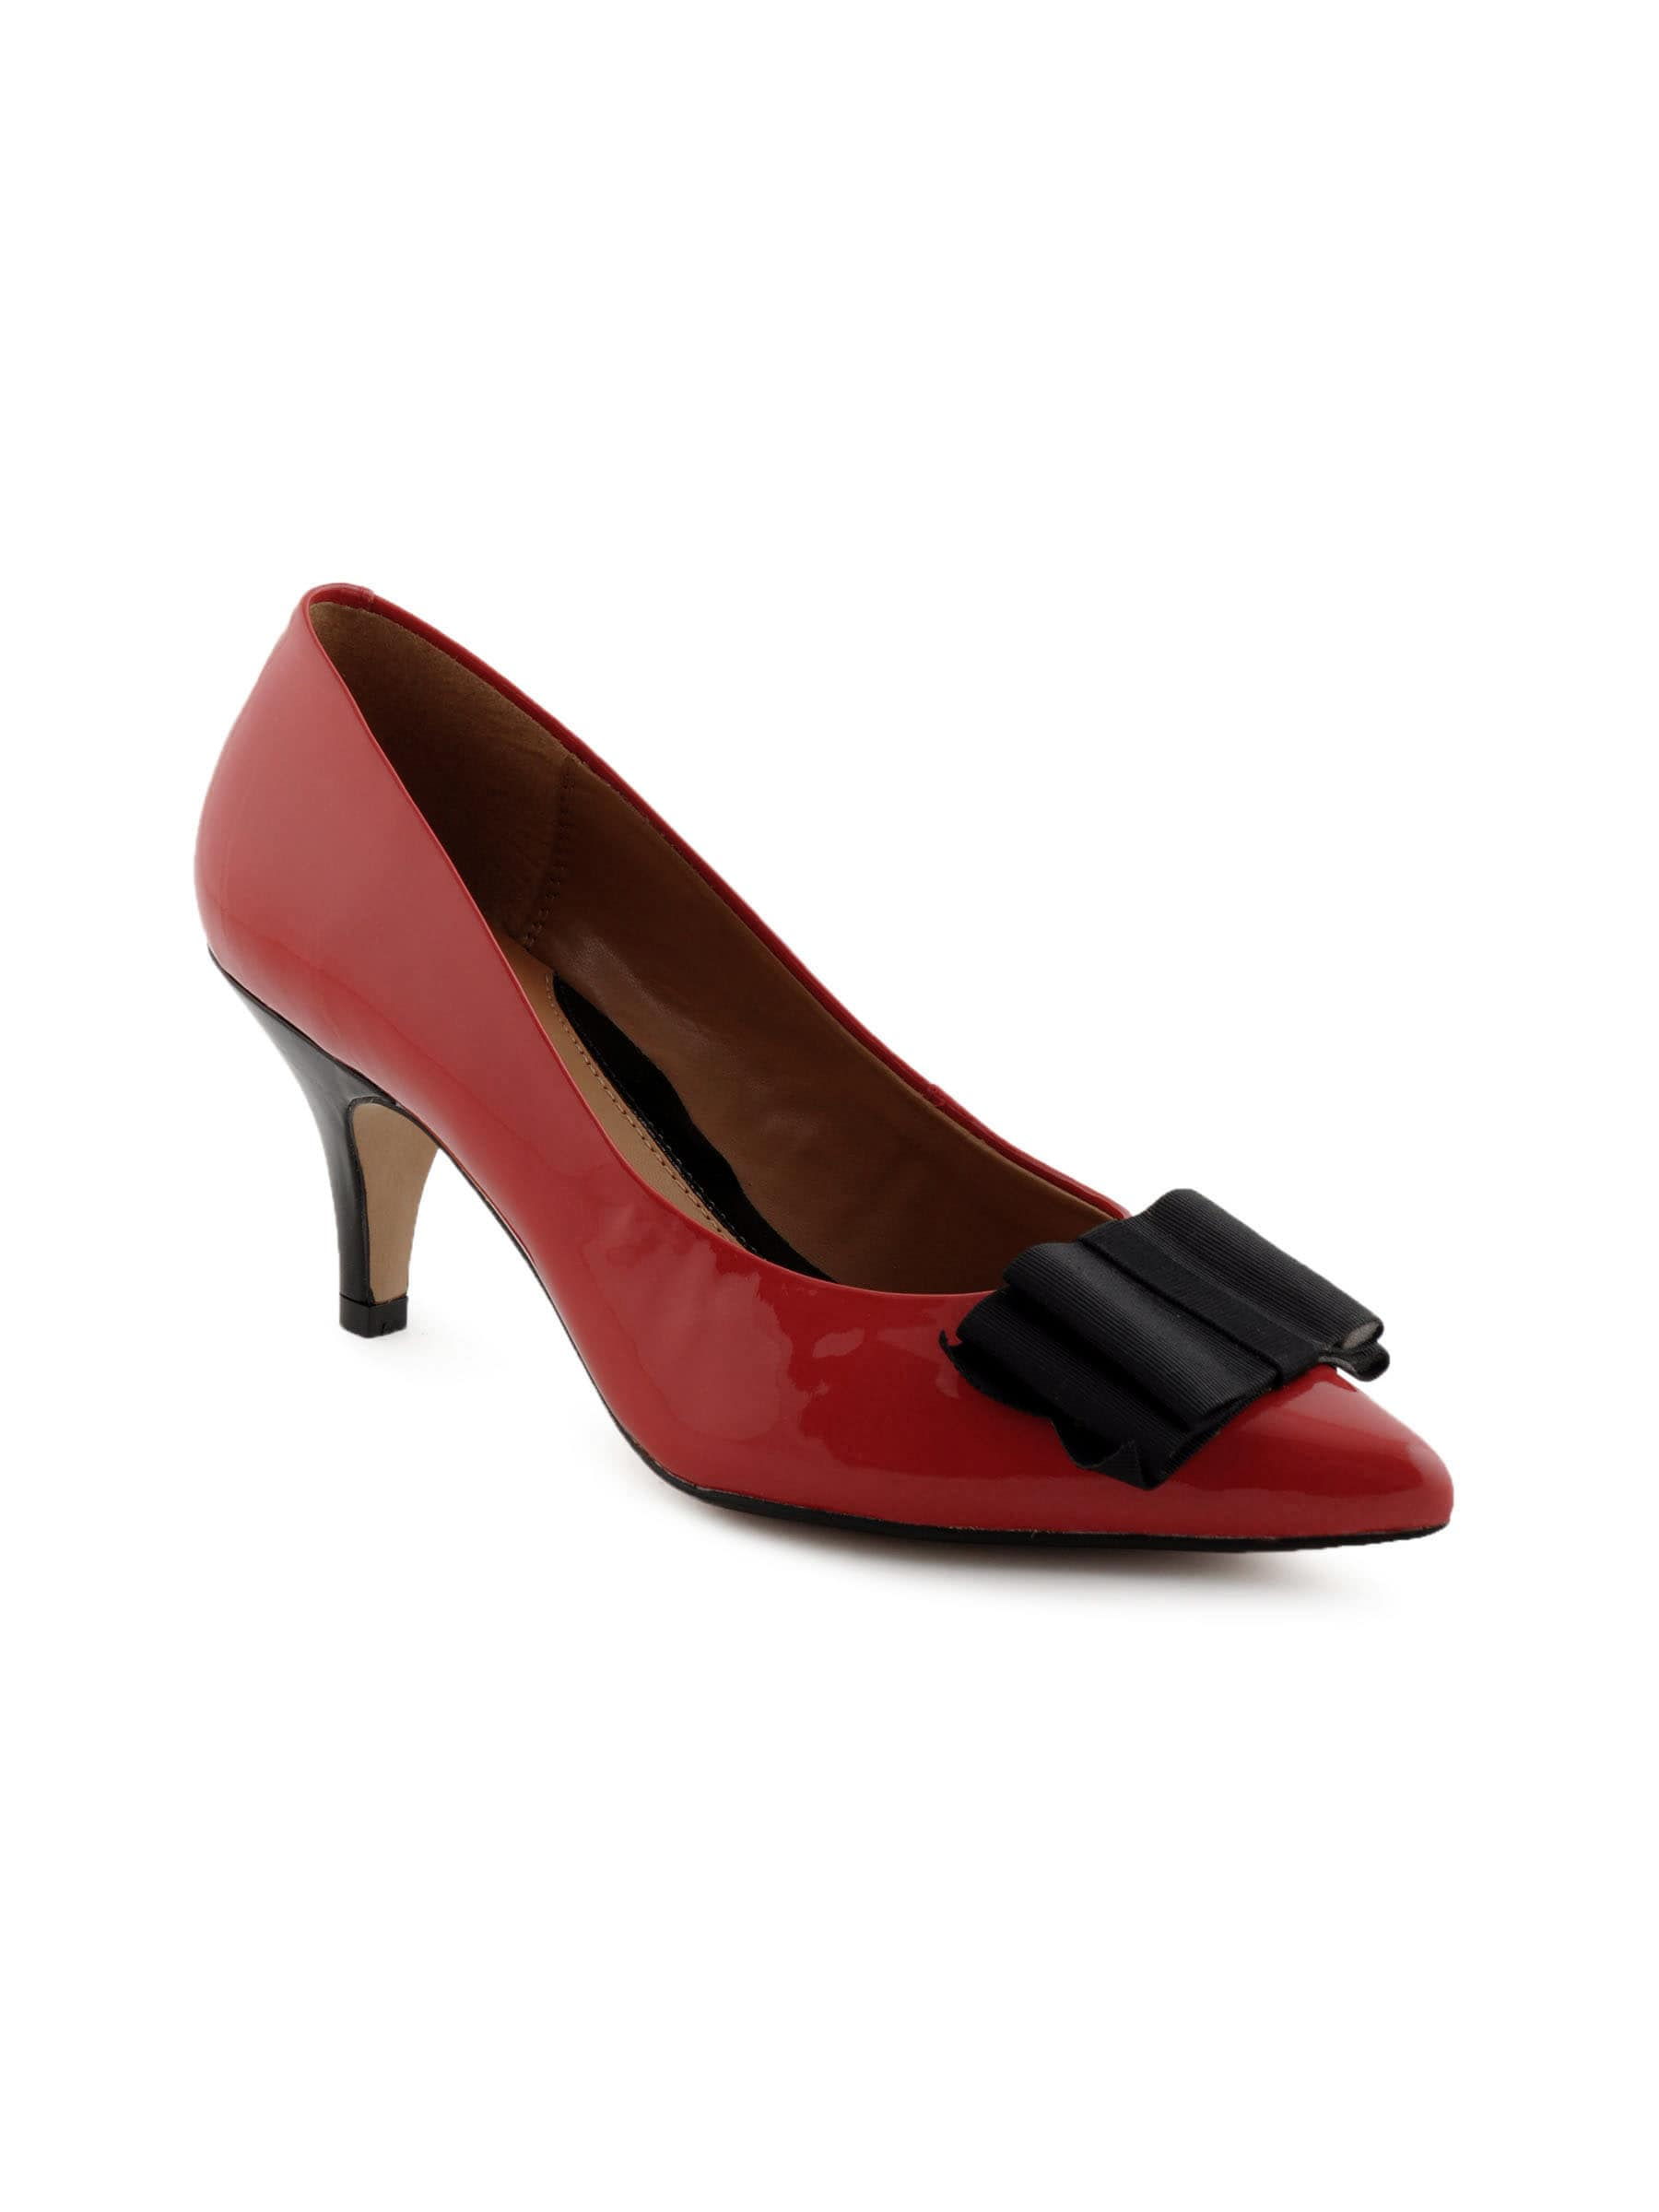

Product Title:  Clarks Women Balti Zing Red Heels

 ==================== Recommended products ====================


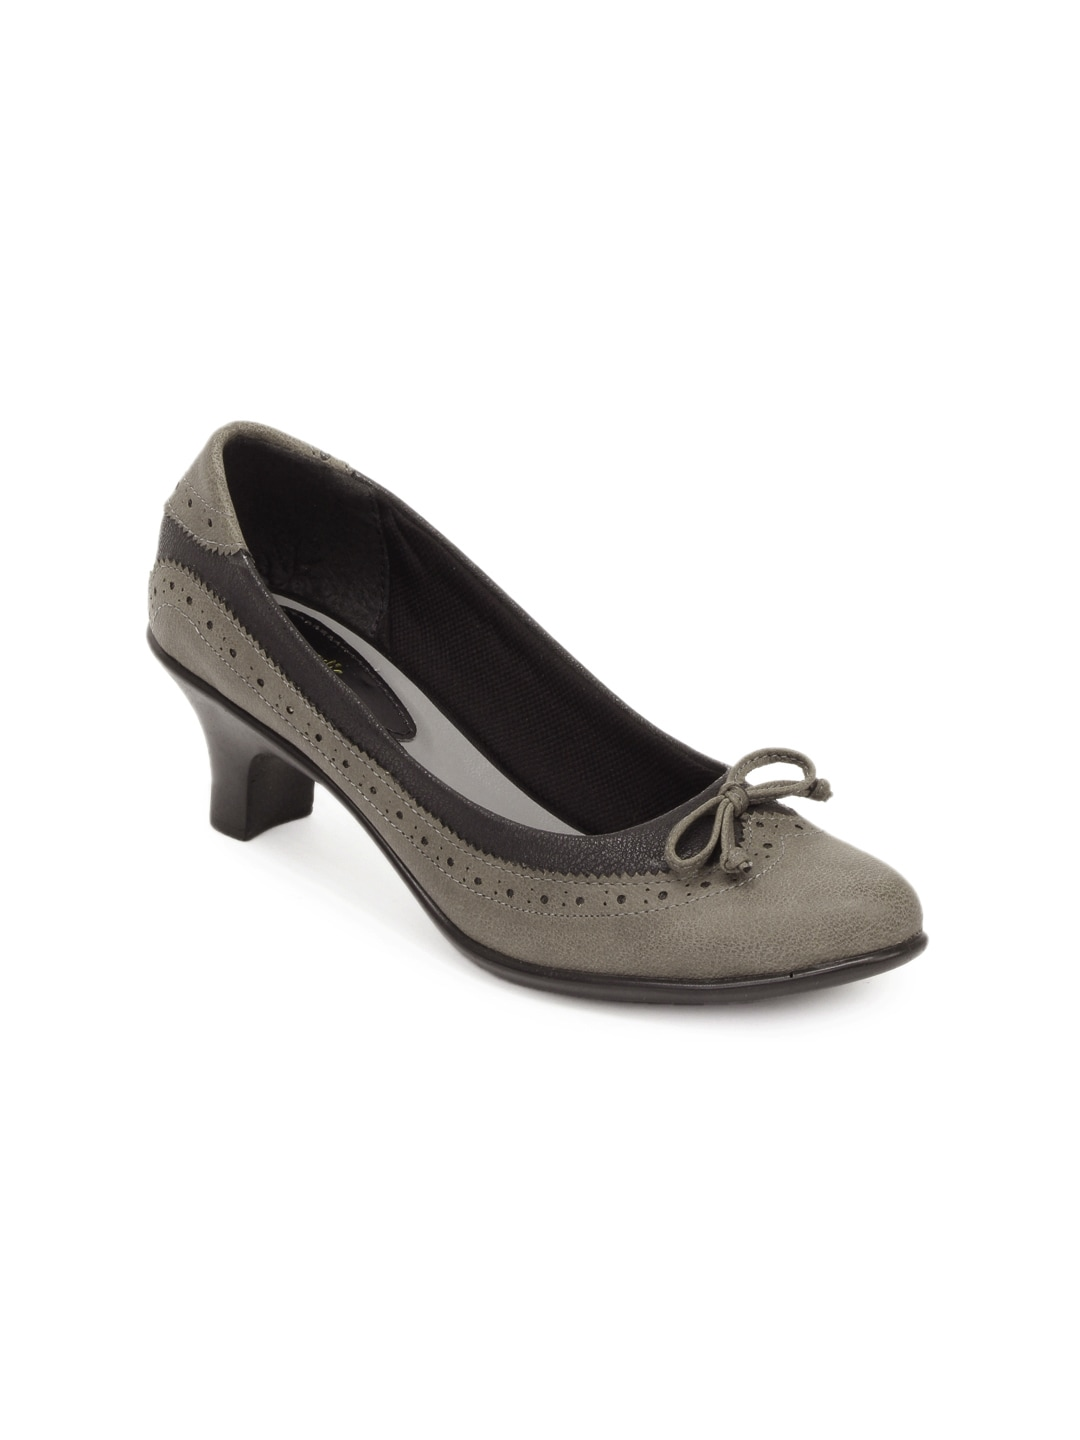

Product Title:  Catwalk Women Black & Grey Heels
Euclidean Distance from input image: 41.760147


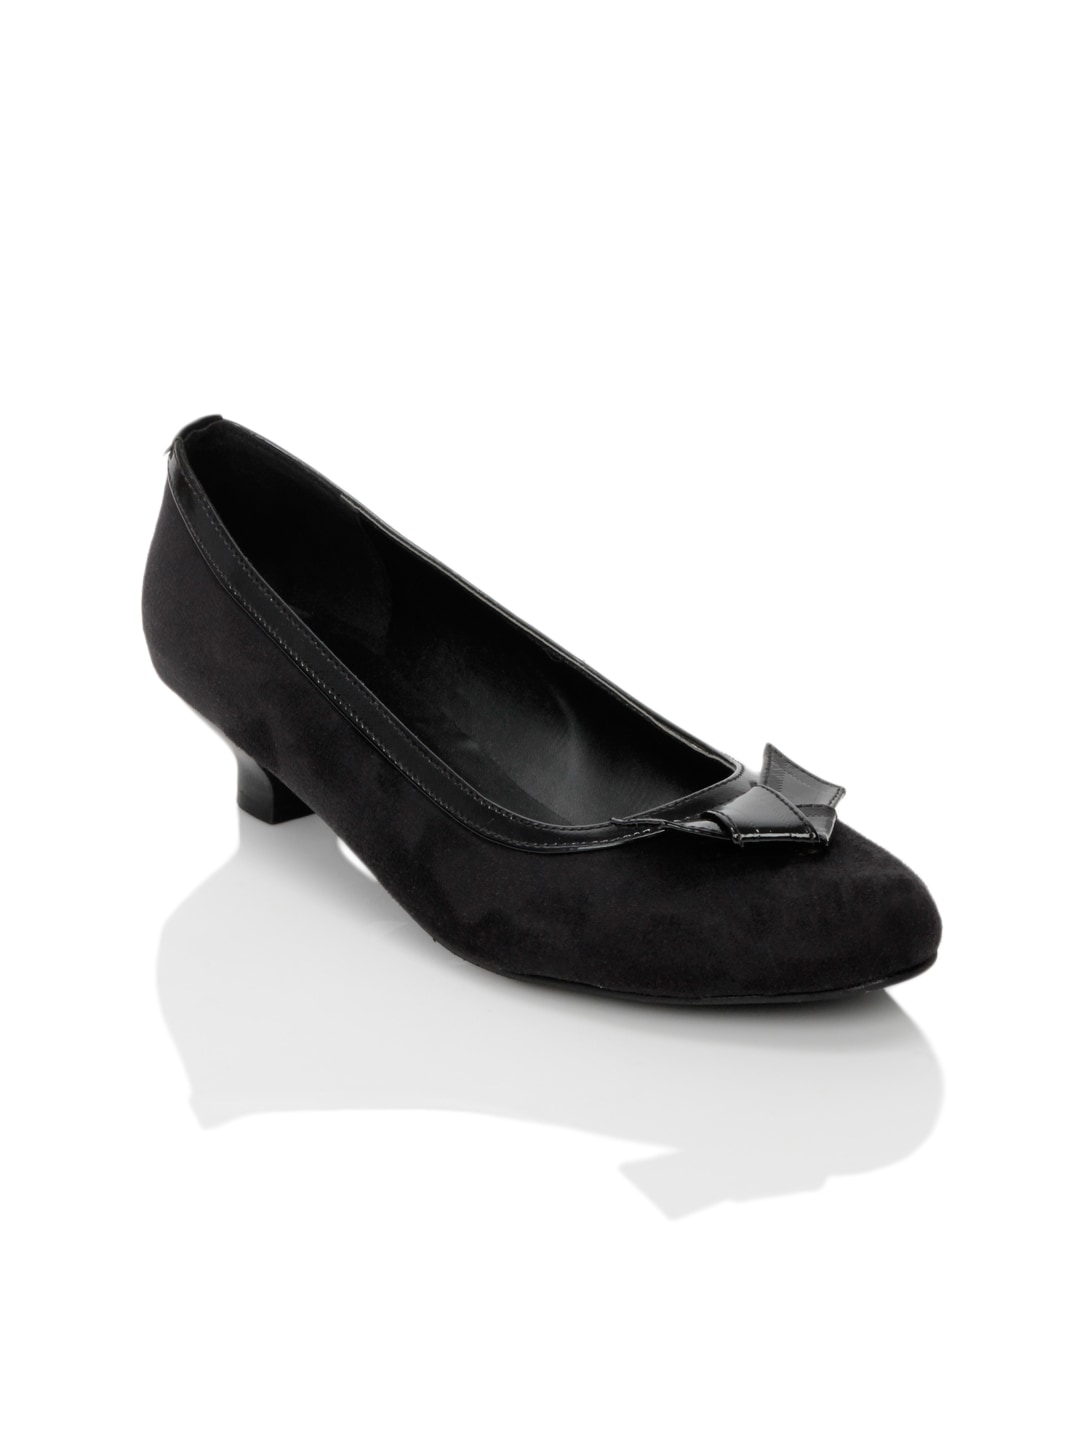

Product Title:  Rocia Women Black Shoes
Euclidean Distance from input image: 44.685703


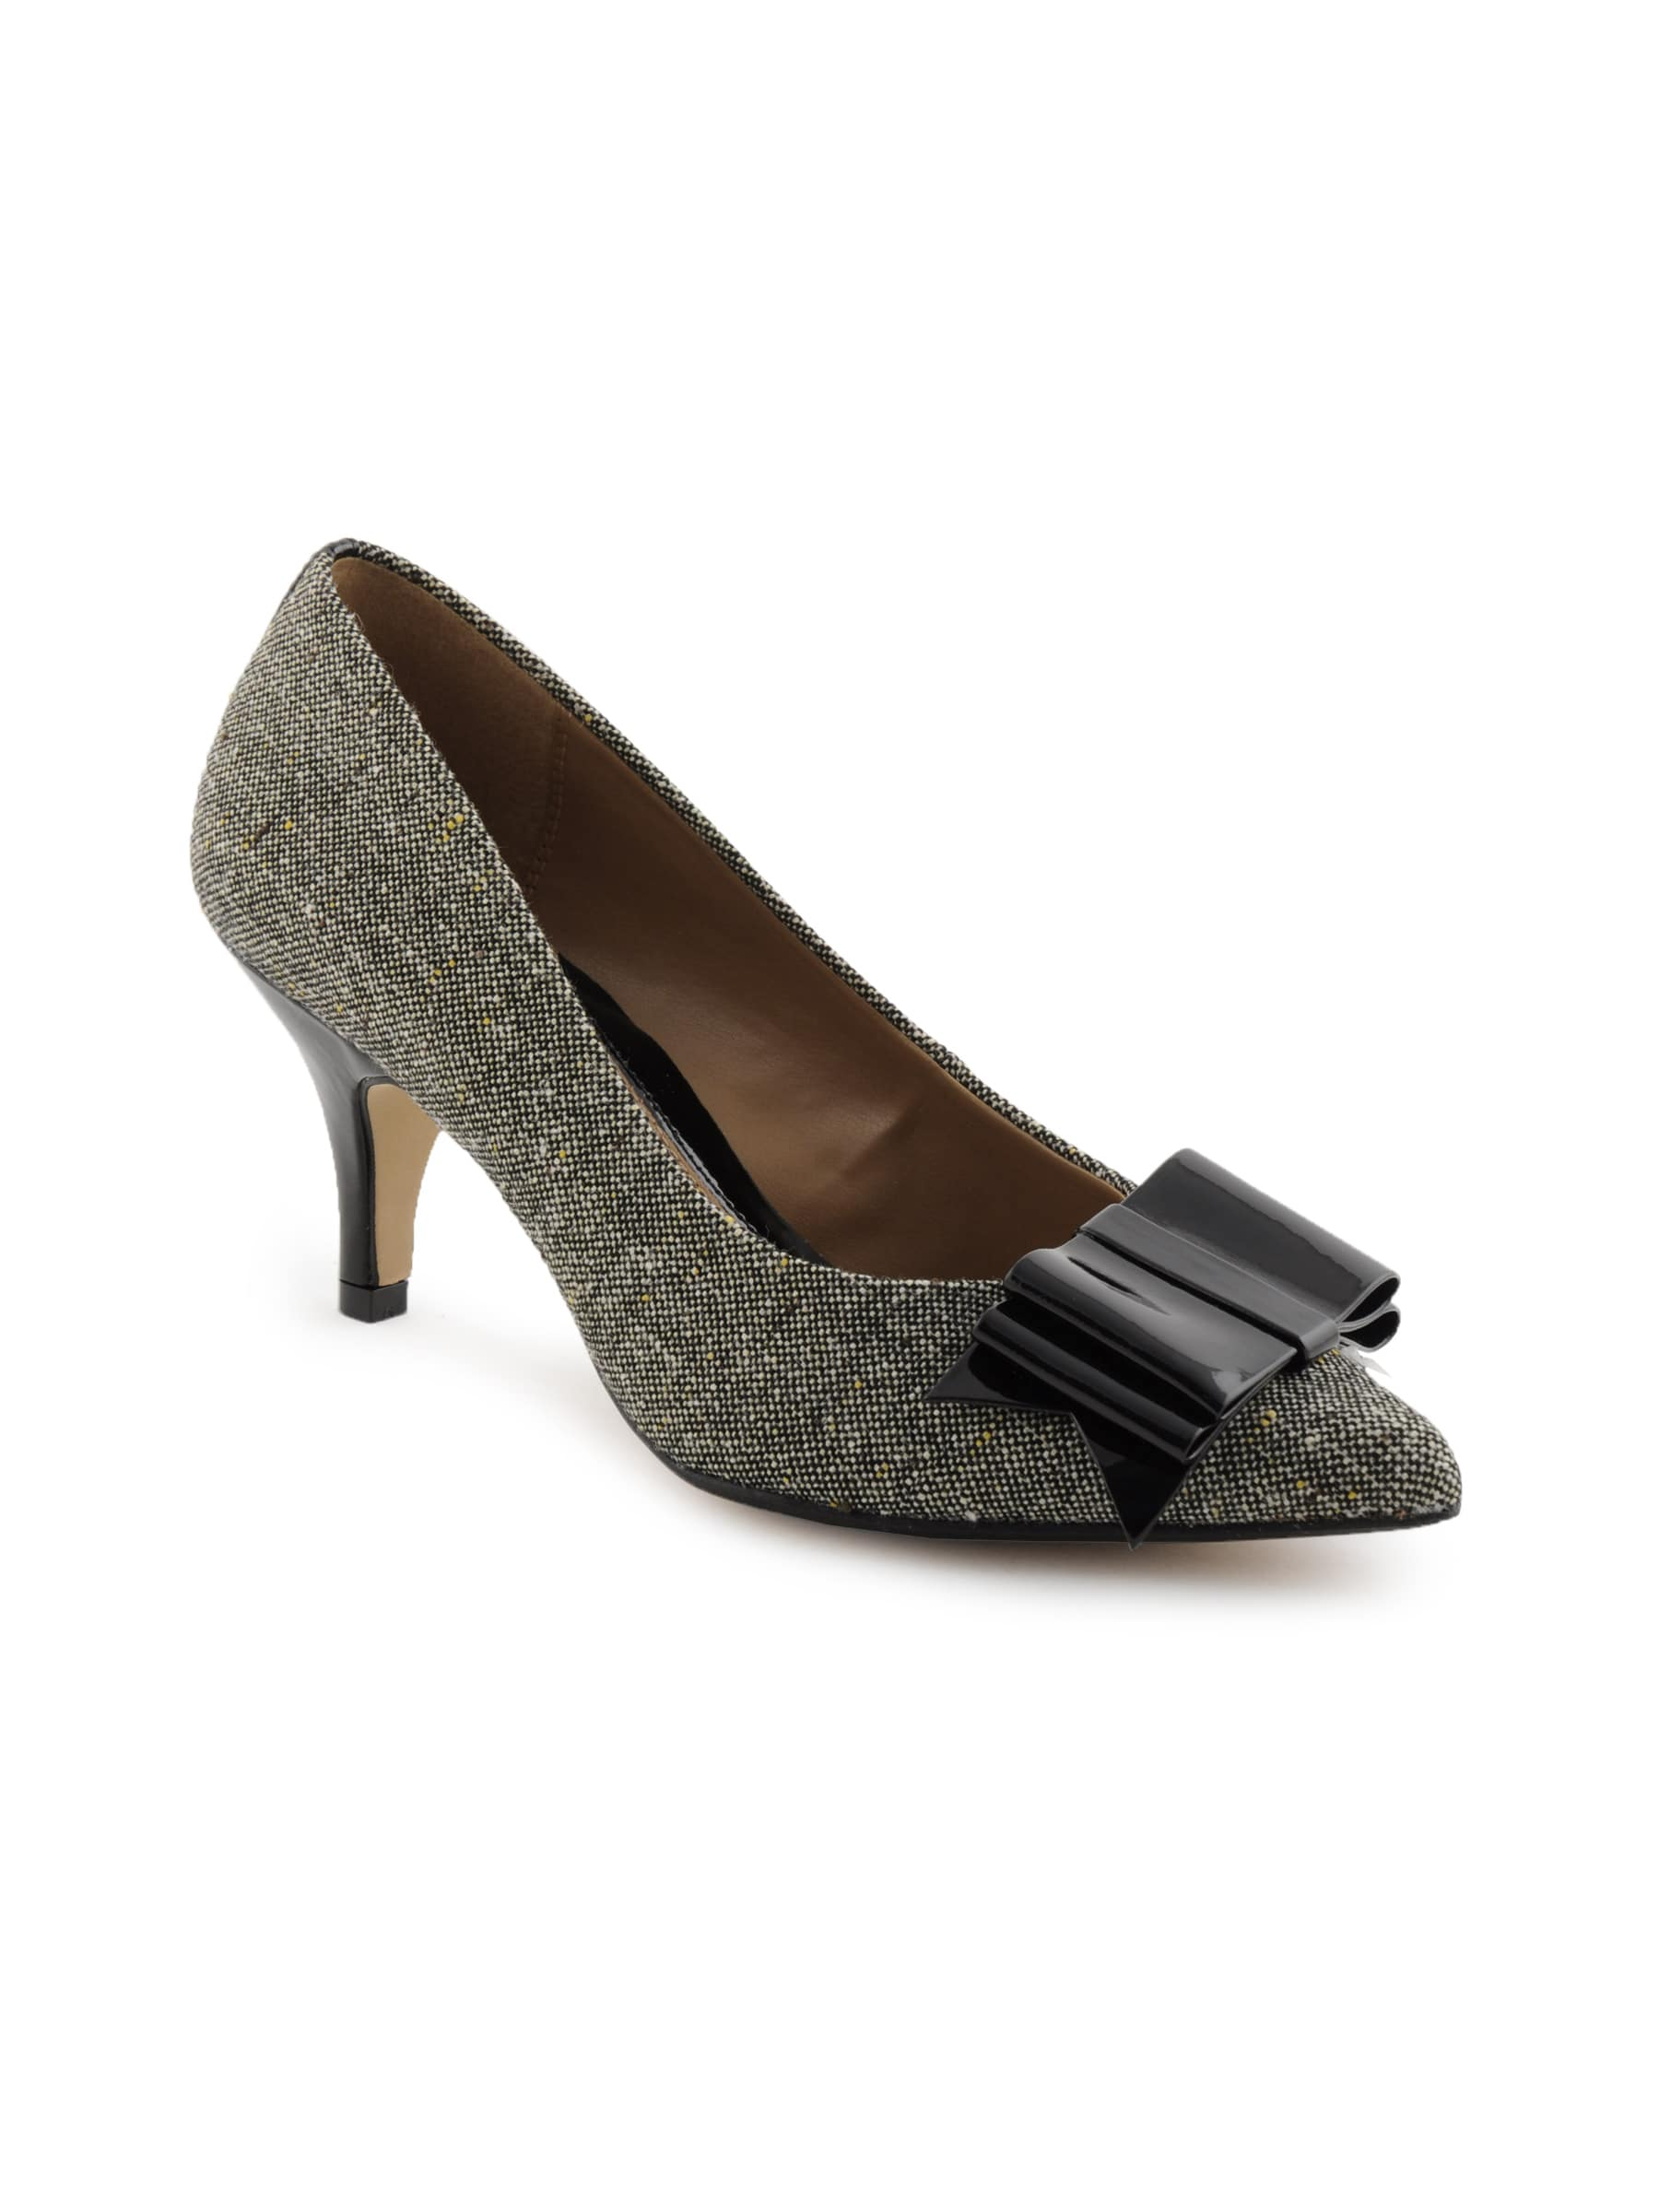

Product Title:  Clarks Women Balti Zing Black Heels
Euclidean Distance from input image: 45.104485


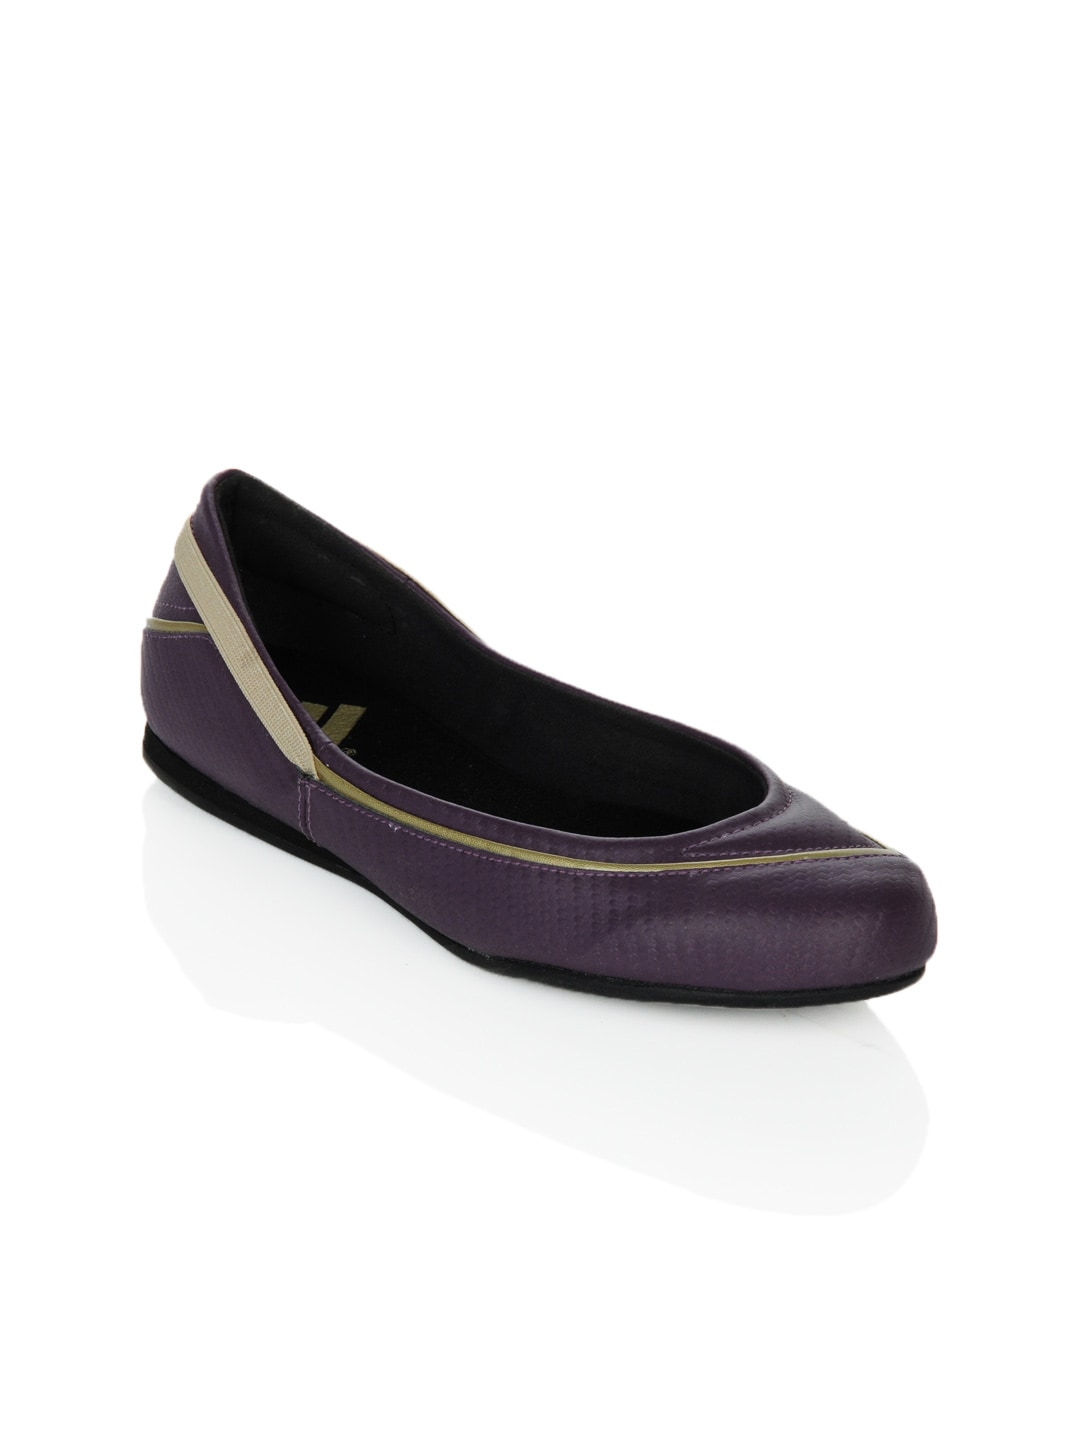

Product Title:  ADIDAS Women Ballerina Purple Shoes
Euclidean Distance from input image: 46.14969


In [ ]:
get_similar_products_cnn('21030', 5)
